## Key Technical Insights

### State Management:
Notice the Annotated[list, operator.add]. This is crucial in LangGraph; it tells the graph to treat the message list as an append-only log, preserving the "thinking" history.

### Tool Binding:
By using .bind_tools(), we provide the LLM with the JSON schema of our Python function. The model doesn't just "guess"; it follows the schema.

### Local Privacy:
Because this uses Ollama, no data leaves your machine. This is the gold standard for enterprise R&D where IP protection is paramount.

### Intermediate Outputs:
The app.stream method allows Gradio to update the UI as the agent moves through different nodes (e.g., from the LLM node to the Tool node).

## Google Colab setup

In [7]:
# 1. Install uv
!pip install -q uv

# 2. Download the TOML file to the local Colab environment
!wget https://raw.githubusercontent.com/rahul-winner/gen_ai_projects/refs/heads/main/pyproject.toml -O pyproject.toml

# 3. Install the dependencies specifically from the pyproject.toml file
!uv pip install --system -r pyproject.toml


--2025-12-26 06:32:38--  https://raw.githubusercontent.com/rahul-winner/gen_ai_projects/refs/heads/main/pyproject.toml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569 [text/plain]
Saving to: ‘pyproject.toml’

pyproject.toml      100%[===================>]     569  --.-KB/s    in 0s      

2025-12-26 06:32:38 (16.8 MB/s) - ‘pyproject.toml’ saved [569/569]

Using Python 3.12.12 environment at: /usr
Resolved 171 packages in 2.86s
Prepared 46 packages in 3.71s
Uninstalled 7 packages in 340ms
Installed 46 packages in 158ms
 + backoff==2.2.1
 + bcrypt==5.0.0
 + build==1.3.0
 + chromadb==1.4.0
 + coloredlogs==15.0.1
 + dataclasses-json==0.6.7
 + ddgs==9.10.0
 + durationpy==0.10
 + fake-useragent==2.2.0
 + filetype==1.2.0
 - google-auth==2.43.0
 + google-auth==2

## Mounting for .env file

In [11]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Install python-dotenv
!pip install python-dotenv -q

# 3. Load the file from your Drive path
import os
from dotenv import load_dotenv

env_path = '/content/drive/MyDrive/ai_api_keys/.env'
load_dotenv(env_path)

# 4. Verify
print(os.getenv("LANGCHAIN_PROJECT"))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pr-giving-strait-89


## Actual code starts from here

In [12]:
import operator
from typing import Annotated, TypedDict

import gradio as gr
from langchain_ollama import ChatOllama
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.tools import tool, StructuredTool

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_openai import ChatOpenAI

import time

### Langsmith integration

In [13]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv(dotenv_path='../.env')

# Verify tracing is enabled
print(f"Tracing enabled: {os.getenv('LANGCHAIN_TRACING_V2')}")
print(f"Project: {os.getenv('LANGCHAIN_PROJECT')}")

Tracing enabled: true
Project: pr-giving-strait-89


In [14]:
def company_charges_fn(source: str, destination: str, days: int) -> float:
    """Looks up current service charges for a given company."""
    return 50.0 + (days * 10.0)  # Dummy implementation

company_service_charges = StructuredTool.from_function(
    func=company_charges_fn,
    name="company_service_charges",
    description="Useful for calculating service charges based on source, destination, and number of days.",
)

In [15]:
def company_affiliations_fn(source: str, destination: str) -> str:
    """Looks up current affiliations for a given company."""
    return """
        Recommend following following hotels: 'MSTDC hotels and resorts', 'The Fern', 'Taj Hotels', 'Sid OYO Rooms'.
        Recommend following ferries: 'Goa Ferries', 'Mandovi River Cruises'.
        Recommend following restaurants: 'MSTDC Restaurants', 'Venite Bar and Restaurant', 'Fisherman's Wharf'.
        Recommend following rentals: 'Zoomcar', 'MSTDC Vehicle Rentals', 'Savaari Car Rentals'.
    """

company_affiliations = StructuredTool.from_function(
    func=company_affiliations_fn,
    name="company_affiliations_service",
    description="Useful for looking up company affiliations to suggest hotels and other services like ferry, restaurant, rentals etc.",
)

In [16]:
def book_flight_func(source: str, destination: str) -> str:
    """
    Internal implementation: Books a flight ticket.

    Args:
        source: Departure city
        destination: Arrival city

    Returns:
        Confirmation message
    """
    return f"Flight booked from {source} to {destination} with Airline XYZ. Confirmation number: ABC123."

book_flight = StructuredTool.from_function(
    func=book_flight_func,
    name="flight_booking_service",
    description="Books flights between major cities. Requires source and destination city names."
)

In [17]:
def book_hotel_fn(city: str, days: int) -> str:
    """Use this for booking hotels/resorts in major cities."""
    return f"Hotel booked in {city}, for {days} days in Marriot hotel."

book_hotel = StructuredTool.from_function(
    func=book_hotel_fn,
    name="hotel_booking_service",
    description="Books hotels in major cities. Requires city name and number of days."
)

In [18]:
# 3. Define Graph State
class AgentState(TypedDict):
    # The 'operator.add' allows us to append messages rather than overwrite
    messages: Annotated[list[BaseMessage], operator.add]

In [19]:
tools = [company_service_charges, company_affiliations, book_hotel, book_flight]
tool_node = ToolNode(tools)

## Planner node

Note - I observed that planner node creates lot of confusion, specially when we bind tools with the model. Sometiems if fails to call the tools.

In [20]:
# 2. Setup the Model with Tools
from pydantic import SecretStr

planner_model = ChatOpenAI(
    model="gpt-oss:120b",
    base_url="https://ollama.com/v1",
    api_key=SecretStr(os.environ['OLLAMA_API_KEY']),
    temperature=0
)

In [21]:
def create_plan(state: AgentState):
    """Creates an execution plan with tool awareness."""
    messages = state["messages"]

    # Get the user's question
    user_message = next((m for m in reversed(messages) if isinstance(m, HumanMessage)), None)

    if user_message:
        # List available tools in the prompt
        tool_descriptions = "\n".join([f"- {tool.name}: {tool.description}" for tool in tools])

        enhanced_planner_prompt = (
            "You are an AI Agent Planning Expert. Analyze the user's request and create a step-by-step execution plan.\n"
            "Break down the request into specific sub-tasks that need to be completed.\n\n"
            f"Available tools:\n{tool_descriptions}\n\n"
            "For each step, identify:\n"
            "1. What needs to be done\n"
            "2. Which tool should be used (if applicable)\n"
            "3. What information to gather or action to perform\n\n"
            "Create ONLY the plan in text format. Do NOT execute any tools."
        )

        planning_messages = [
            SystemMessage(content=enhanced_planner_prompt),
            HumanMessage(content=f"User request: {user_message.content}")
        ]

        # Get plan
        response = planner_model.invoke(planning_messages)

        # Handle response content
        plan = response.content if isinstance(response.content, str) else str(response.content)

        if plan and plan.strip():
            plan_message = AIMessage(content=f"📋 **Execution Plan:**\n\n{plan}\n\n---\n")
            return {"messages": [plan_message]}
        else:
            # Fallback - skip planning if it fails
            print("WARNING: Plan generation failed, skipping to agent")
            return {"messages": []}

    return {"messages": []}


In [22]:
# 2. Setup the Model with Tools
model = ChatOpenAI(
    model="gpt-oss:120b",
    base_url="https://ollama.com/v1",
    api_key=SecretStr(os.environ['OLLAMA_API_KEY']),
    temperature=0
).bind_tools(tools)

In [23]:
# 4. Define Logic Nodes

system_prompt = (
    "You are an expert Travel Planner. To provide a high-quality response, you MUST follow these steps:\n"
    "1. MUST call and give precedence to provided tools.\n"
    "4. Use 'flight_booking_service' to book flights and 'hotel_booking_service' to book accommodations.\n"
    "5. Only provide the final itinerary AFTER all tool results are gathered.\n"
    "6. Recommend hotels, ferries, restaurants, rentals based on company affiliations using 'company_affiliations_service' if required.\n"
    "7. Make some reasonable assumptions about dates and preferences if not provided by the user. NO NEED TO ASK FOR CLARIFICATION.\n"
    "** IMPORTANT **\n"
    "- Do not show obscenities in the final response.\n"
    "Note: Execute the tools as per the plan step-by-step, ensuring each tool's output is considered before finalizing your response."
)


def call_model(state: AgentState):
    messages = state["messages"]

    # Find if there's a plan message
    print(f"==>>> DEBUG: Checking for plan message in messages: {[str(m.content) for m in messages]}")
    plan_message = next((m for m in messages if isinstance(m, AIMessage) and "📋 **Execution Plan:**" in str(m.content)), None)

    # Build enhanced system prompt with plan if available
    enhanced_system_prompt = system_prompt
    if plan_message:
        plan_text = plan_message.content.replace("📋 **Execution Plan:**", "").replace("---", "").strip()
        enhanced_system_prompt = (
            f"{system_prompt}\n\n"
            f"EXECUTION PLAN TO FOLLOW:\n{plan_text}\n\n"
            f"Execute this plan step by step using the available tools."
        )
        # Remove plan message from conversation
        messages = [m for m in messages if m != plan_message]

    # Add/update system prompt
    if not any(isinstance(m, SystemMessage) for m in messages):
        messages = [SystemMessage(content=enhanced_system_prompt)] + messages
    else:
        # Replace existing system message
        messages = [SystemMessage(content=enhanced_system_prompt)] + [m for m in messages if not isinstance(m, SystemMessage)]

    response = model.invoke(messages)
    return {"messages": [response]}


In [24]:
def should_continue(state: AgentState):
    """Router to determine the next step."""
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"
    return END

## Graph

In [25]:
# 5. Build the Graph - UPDATED with planner node
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("planner", create_plan)  # Planning node with tool awareness
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set flow
workflow.set_entry_point("planner")  # Start with planning
workflow.add_edge("planner", "agent")  # Plan -> Execute
workflow.add_conditional_edges("agent", should_continue, {"tools": "tools", END: END})
workflow.add_edge("tools", "agent")  # After tools, go back to agent

app = workflow.compile()


In [26]:
# --- ENHANCED UI Logic for Multi-Turn Reasoning ---
def agent_chat(user_input, history):
    # Start with a fresh state for each new query
    inputs = AgentState({"messages": [HumanMessage(content=user_input)]})

    full_display_content = ""  # This accumulates for final display
    step_num = 1
    processed_message_count = 0  # Track how many messages we've processed

    # We use stream to capture every transition in the graph
    for output in app.stream(inputs, stream_mode="values"):
        messages = output["messages"]

        # Process only NEW messages we haven't seen yet
        new_messages = messages[processed_message_count:]

        for msg in new_messages:
            # 1. AGENT IS THINKING/PLANNING
            if isinstance(msg, AIMessage) and msg.tool_calls:
                for tool_call in msg.tool_calls:
                    tool_name = tool_call["name"]
                    thinking_message = "🤔 thinking...\n"
                    thinking_message += f"   - checking {tool_name.replace('_', ' ')}...`\n\n"

                    # Add to full content for final display
                    full_display_content += thinking_message
                    step_num += 1

                    # Yield ONLY current step (not accumulated content)
                    yield thinking_message
                    time.sleep(1)  # Simulate thinking time

            # 2. TOOL IS EXECUTING
            elif isinstance(msg, ToolMessage):
                tool_name = msg.name or ""
                result_message = f"📥  {tool_name.replace('_', ' ')} response: \n"
                result_message += f"   - Output: {msg.content[:200]}...\n\n"

                # Add to full content for final display
                full_display_content += result_message

                # Yield ONLY current result (not accumulated content)
                yield result_message
                time.sleep(1)  # Simulate execution time

            # 3. FINAL SYNTHESIS - Show complete flow
            elif isinstance(msg, AIMessage) and not msg.tool_calls and "**Execution Plan:**" not in msg.content:
                final_output = full_display_content  # All accumulated steps
                final_output += "---\n### 🏁 Final Answer\n\n"
                content = msg.content if isinstance(msg.content, str) else str(msg.content)
                final_output += content

                # Yield complete flow with final answer
                yield final_output

        # Update the count of processed messages
        processed_message_count = len(messages)

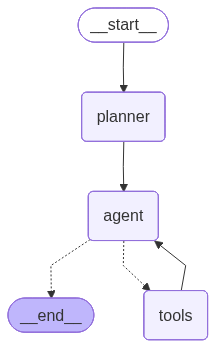

In [27]:
from IPython.display import Image, display

# Replace 'app' with the name of your compiled graph
display(Image(app.get_graph().draw_mermaid_png()))

In [58]:
# Launch UI
view = gr.ChatInterface(
    fn=agent_chat,
    title="LangGraph Local Agent (Ollama)",
    description="Ask me about travel, climate etc. . I'll show you my thinking process.",
    examples=["Create an itinerary for a 5 days trip to Goa from Pune for 1st week of January 2026. Dates are flexible and do the bookings.",
              "please plan a 3 days trip to bhutan from Pune in first week of February 2026. Include hotel and flight bookings."]
)

view.launch()

Using Python 3.12.12 environment at: /usr
Resolved 65 packages in 1.03s
Prepared 65 packages in 5ms
Uninstalled 65 packages in 158ms
Installed 65 packages in 182ms
 ~ aiofiles==23.2.1
 ~ altair==5.5.0
 ~ annotated-doc==0.0.4
 ~ annotated-types==0.7.0
 ~ anyio==4.12.0
 ~ attrs==25.4.0
 ~ certifi==2025.11.12
 ~ click==8.3.1
 ~ contourpy==1.3.3
 ~ cycler==0.12.1
 ~ fastapi==0.127.0
 ~ ffmpy==1.0.0
 ~ filelock==3.20.1
 ~ fonttools==4.61.1
 ~ fsspec==2025.12.0
 ~ gradio==4.36.1
 ~ gradio-client==1.0.1
 ~ h11==0.16.0
 ~ hf-xet==1.2.0
 ~ httpcore==1.0.9
 ~ httpx==0.28.1
 ~ huggingface-hub==1.2.3
 ~ idna==3.11
 ~ importlib-resources==6.5.2
 ~ jinja2==3.1.6
 ~ jsonschema==4.25.1
 ~ jsonschema-specifications==2025.9.1
 ~ kiwisolver==1.4.9
 ~ markdown-it-py==4.0.0
 ~ markupsafe==2.1.5
 ~ matplotlib==3.10.8
 ~ mdurl==0.1.2
 ~ narwhals==2.14.0
 ~ numpy==2.4.0
 ~ orjson==3.11.5
 ~ packaging==25.0
 ~ pandas==2.3.3
 ~ pillow==10.4.0
 ~ pydantic==2.12.5
 ~ pydantic-core==2.41.5
 ~ pydub==0.25.1
 ~ pygm

Exception in thread Thread-118 (run):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/server.py", line 67, in run
    return asyncio_run(self.serve(sockets=sockets), loop_factory=self.config.get_loop_factory())
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/asyncio/runners.py", line 195, in run
    return runner.run(main)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "uvloop/loop.pyx", line 1518, in uvloop.loop.Loop.run_until_complete
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/server.py", line 71, in serve
    await

KeyboardInterrupt: 